In [195]:
import os
import datetime
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import glob
import scipy.io as sio

import netCDF4 as nc
from salishsea_tools import (tidetools, teos_tools)
from nowcast import (analyze, figures, research_ferries_test as rft)

%matplotlib inline

In [13]:
from importlib import reload

In [161]:
period = '1h'
grid = 'grid_T'
dmy = '11dec15'
date = datetime.datetime.strptime(dmy, "%d%b%y")
dayf = date - datetime.timedelta(days=1)
dmyf = dayf.strftime('%d%b%y').lower()
print(dmyf)

10dec15


Step 0: Load the datasets and files that are available in nowcast/make_plots. 
These will be used as inputs, not to be reloaded in the module

In [202]:
grid_T_hr = nc.Dataset(analyze.get_filenames(date, date, period, grid, '/results/SalishSea/nowcast/')[0])
coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_SS2_bathy_data()

## A : Preparing ferry data
Step 1: Get ferry data

In [203]:
route_name='TWDP'
start_time = date.replace(hour=rft.route[route_name]['start']['hour'], minute=rft.route[route_name]['start']['minute'])
end_time = date.replace(hour=rft.route[route_name]['end']['hour'], minute=rft.route[route_name]['end']['minute'])
print(start_time, end_time)

2015-12-11 02:00:00 2015-12-11 04:15:00


In [100]:
obs = rft._get_sal_data(route_name, dmyf)

Step 2: Slicing ferry data

In [214]:
obs_sal = rft.ferry_salinity(route_name, dmy)

[[  7.36309083e+05   7.36309086e+05   7.36309088e+05   7.36309090e+05
    7.36309093e+05   7.36309095e+05   7.36309097e+05   7.36309100e+05
    7.36309102e+05   7.36309104e+05   7.36309107e+05   7.36309109e+05
    7.36309111e+05   7.36309114e+05   7.36309116e+05   7.36309118e+05
    7.36309120e+05   7.36309123e+05   7.36309125e+05   7.36309127e+05
    7.36309130e+05   7.36309132e+05   7.36309134e+05   7.36309137e+05
    7.36309139e+05   7.36309141e+05   7.36309144e+05   7.36309146e+05
    7.36309148e+05   7.36309151e+05   7.36309153e+05   7.36309155e+05]
 [ -1.23869200e+02  -1.23843828e+02  -1.23818181e+02  -1.23792430e+02
   -1.23768940e+02  -1.23745451e+02  -1.23721504e+02  -1.23697344e+02
   -1.23673123e+02  -1.23649132e+02  -1.23626043e+02  -1.23604040e+02
   -1.23582064e+02  -1.23559932e+02  -1.23537883e+02  -1.23516118e+02
   -1.23494455e+02  -1.23472762e+02  -1.23451437e+02  -1.23429964e+02
   -1.23407576e+02  -1.23385087e+02  -1.23362596e+02  -1.23337306e+02
   -1.23311629e+02 

## B: Preparing model data

In [126]:
sal_a, sal_b = rft._get_nemo_salinity('TWDP', grid_T_hr)
print(sal_a, sal_b.shape)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] (898, 398)


## C: Find corresponding model point to obs data
For each ferry route point we want to find the closest model point. From that model point we then find the 8 nearest points and compute and inverse distance interpolation.

In [170]:
rft.model_IDW(obs_sal[:,1], bathy, grid_T_hr, sal_a, sal_b)

(28.537314072515599, 28.532553847031014)

In [169]:
sal_val, sal_val_b = rft.nemo_sal_route(grid_T_hr, bathy, route_name, obs_sal)
print(sal_val_b)

(32,)
[ 27.87248315  28.53255385  28.79126316  29.38256732  29.46312125
  29.45207253  29.35544635  29.17995146  29.11080906  29.14811696
  29.09741056  28.93519117  28.62515245  28.45624218  28.20283451
  28.16431215  28.20376919  28.27219217  28.3244454   28.36194117
  28.47939304  28.71063895  28.8213193   28.90234293  29.02816848
  29.1352103   29.16165714  29.20917199  29.28180829  29.34660849
  29.40272509  29.3080581 ]


In [219]:
reload(rft)

<module 'nowcast.research_ferries_test' from '/ocean/mdunn/MEOPAR/tools/SalishSeaNowcast/nowcast/research_ferries_test.py'>

/home/mdunn/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


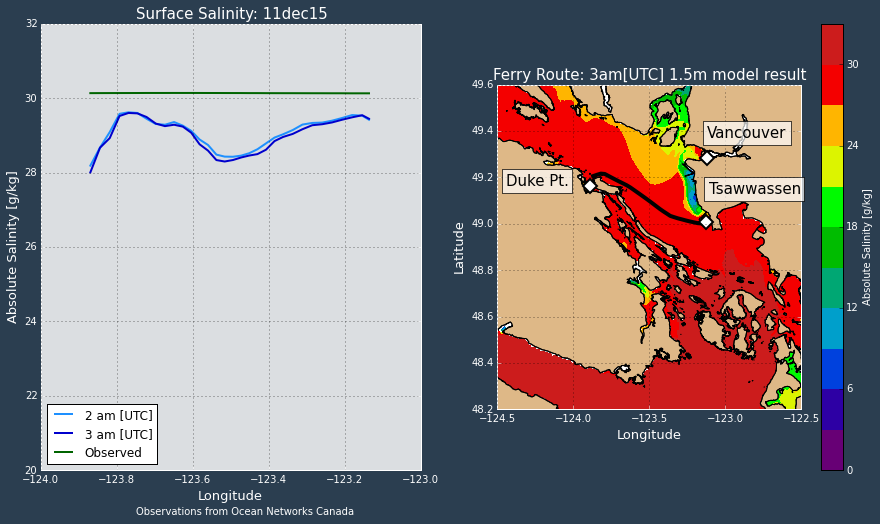

In [220]:
fig = rft.salinity_ferry_route(grid_T_hr, grid_B, bathy, coastline, 'TWDP', dmy)